# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски.

Шаги для выбора локации:

- В избранном регионе ищем месторождения, для каждого определяем значения признаков;
- Строим модель и оцениваем объём запасов;
- Выбираем месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений

# Задача
1. **Построить модель для определения региона, где добыча принесёт наибольшую прибыль.**
2. **Проанализировать возможную прибыль и риски.**

# Загрузка и подготовка данных

In [2]:
# импорт данных 
import os
from urllib.request import urlretrieve
from IPython.display import display
from pathlib import Path
import urllib


# Основные библиотеки для работы с данными
import pandas as pd
import numpy as np

# работа с графиками
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display
from PIL import Image

# библиотека для модели
from sklearn.linear_model import LinearRegression

# Настройка моделей и параметров (разбивка датасета, его перемешивание и т.д.)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from itertools import product 

# Наши основные показатели
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from scipy import stats as st
from scipy.stats import t
from numpy.random import RandomState
import urllib
import urllib.request


In [3]:
# отключение предупреждений
import warnings; warnings.filterwarnings("ignore", category=Warning)

In [4]:
# обновление библиотек Numpy и Pandas для исключения ошибок версий
# !pip3 install --upgrade --user --quiet --no-warn-script-location numpy==1.20.1 pandas

In [5]:
# для просмотра всех столбцов таблицы
pd.options.display.max_columns = None

In [6]:
# # обновление библиотек
# !pip3 install --upgrade --user --quiet matplotlib seaborn

In [7]:
# # обновление библиотек
# !pip3 install --upgrade --user --quiet sklearn

## Загрузка данных

In [8]:
def load_from_url(file_url, file_path):
    """Загрузка файла из сетевого источника и загрузка в file_path"""
    folder_path = os.path.dirname(file_path)
    if not os.path.exists(folder_path):
        print('Создаем папку {folder_path}')
        os.makedirs(folder_path)
        print(f'Закгружаю файл из "{file_url}" в "{file_path}" ... ', end='')
        result = urllib.urlretrieve(url=file_url, filename=file_path) 
        print('OK')
        return result



In [9]:
def get_data_frame(file_path, *args, **kwqrgs):
    """Загружаю файл из локального файла file_path"""
    print(f'Открываю "{file_path}" с помошью Pandas ...', end='')
    result = pd.read_csv(file_path, *args, **kwqrgs)
    print('OK')
    return result
    

In [10]:
# 
def load_dataframe(file_url, file_path, *args, **kwqrgs):
    if os.path.isfile(file_path):
        print(f'Файл "{file_path}" уже был ранее заргужен.')
    else:
        load_from_url(file_url, file_path)
#     Создаем датафрейм
    return get_data_frame(file_path, *args, **kwqrgs)
    

In [11]:
dataset_url0 = 'https://code.s3.yandex.net/datasets/geo_data_0.csv'
dataset_url1 = 'https://code.s3.yandex.net/datasets/geo_data_1.csv'
dataset_url2 = 'https://code.s3.yandex.net/datasets/geo_data_2.csv'

dataset_path0 = 'D:/projects/geo_data_0.csv'
dataset_path1 = 'D:/projects/geo_data_1.csv'
dataset_path2 = 'D:/projects/geo_data_2.csv'

In [12]:
raw_data0 = load_dataframe(dataset_url0, dataset_path0)
raw_data1 = load_dataframe(dataset_url1, dataset_path1)
raw_data2 = load_dataframe(dataset_url2, dataset_path2)

Файл "D:/projects/geo_data_0.csv" уже был ранее заргужен.
Открываю "D:/projects/geo_data_0.csv" с помошью Pandas ...OK
Файл "D:/projects/geo_data_1.csv" уже был ранее заргужен.
Открываю "D:/projects/geo_data_1.csv" с помошью Pandas ...OK
Файл "D:/projects/geo_data_2.csv" уже был ранее заргужен.
Открываю "D:/projects/geo_data_2.csv" с помошью Pandas ...OK


## Описание данных  и подготовка к анализу
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек;
- product — объём запасов в скважине (тыс. баррелей).

In [13]:
# Делаем функцию которая будет описывать данные для каждого датафрейма
def data_analysis(loc, name):
    print(name + '\n' + '-' * 50)
    loc.info()
    print('-' * 50)
    print('head()')
    display(loc.head(3))
    print('-' * 50)
    print('nunique()')
    display(loc.nunique())
    print('-' * 50)
    print('Полных дубликатов -', loc.duplicated().sum())
    print('-' * 50)
    print('describe()')
    display(loc.describe().transpose())
    print('-' * 50)
    print('corr()')
    display(loc.corr())
    g=sns.pairplot(loc)
    g.fig.suptitle(f'Распределения и зависимости признаков в регионе "{name}"', y=1.08)
    print()

### Регион №1

Well1
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
--------------------------------------------------
head()


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


--------------------------------------------------
nunique()


id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

--------------------------------------------------
Полных дубликатов - 0
--------------------------------------------------
describe()


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


--------------------------------------------------
corr()


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


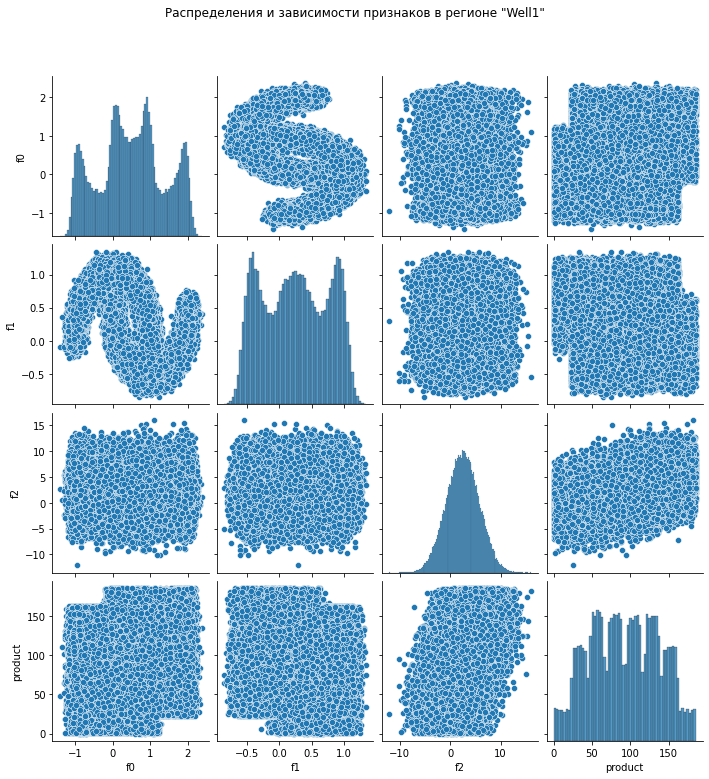

In [14]:
data_analysis(raw_data0, 'Well1')

#### Вывод по региону 1

Данные нормальные. Нет пропусков и дубликатов. Также не видно сильных аномалий

### Регион №2

Well2
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
--------------------------------------------------
head()


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


--------------------------------------------------
nunique()


id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

--------------------------------------------------
Полных дубликатов - 0
--------------------------------------------------
describe()


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


--------------------------------------------------
corr()


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


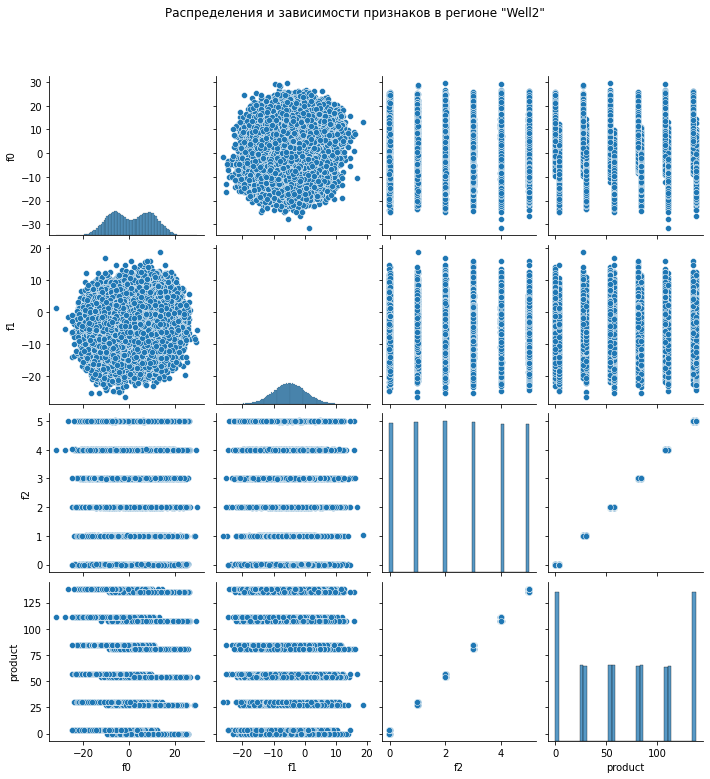

In [15]:
data_analysis(raw_data1, 'Well2')

#### Вывод по региону 2

Данные нормальные. Нет пропусков и дубликатов. Не видно сильных аномалий.

Также есть интересная особенность параметр f2 очень сильно коррелирует с цеелвым признаком. Далее мы попробуем только на этом признаке обучить модель, посмотрим что из этого получится.

### Регион №3


Well3
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
--------------------------------------------------
head()


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


--------------------------------------------------
nunique()


id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

--------------------------------------------------
Полных дубликатов - 0
--------------------------------------------------
describe()


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


--------------------------------------------------
corr()


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


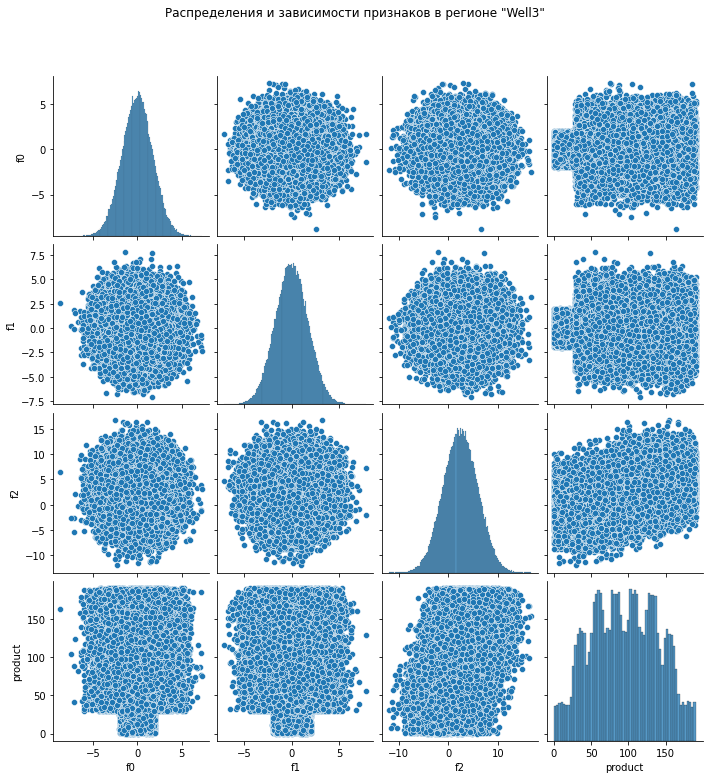

In [16]:
data_analysis(raw_data2, 'Well3')

#### Вывод по региону 3

Данные нормальные. Нет пропусков и дубликатов. Не видно сильных аномалий.

# Обучение и проверка модели

In [17]:
# Зададим значения randomState для получения одинаковых результатов
randomState = 42
state = RandomState(randomState) 

## Регион №1

In [18]:
# Выделяем отдельно признаки, отдельно целевой признак
# Столбец id нам также не нужен для обучения
features0 = raw_data0.drop(['product', 'id'], axis=1) 
target0 = raw_data0['product']
# features0

In [19]:
# Делим датаест на обучающую и валидационную выборки
features_train0, features_valid0, target_train0, target_valid0 = train_test_split(
    features0, target0, test_size=0.25, random_state=randomState)

In [20]:
# Наша модель которая будет делать все предсказания
model = LinearRegression()

In [21]:
# Функция вывода всей нужной нам информации о модели
def model_specifications(features_train, features_valid, target_train, target_valid):
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = mean_squared_error(target_valid, predictions_valid)**0.5 # RMSE на валидационной выборке
    print("RMSE модели линейной регрессии на валидационной выборке: {:.2f}".format(result))

    raw_material_stock_pred = predictions_valid.mean()
    raw_material_stock_real = target_valid.mean()
    print('Средний запас предсказанного сырья - {:.2f}'.format(raw_material_stock_pred))
    print('Средний запас реального сырья - {:.2f}'.format(raw_material_stock_real))
    confidence_interval = t.interval(0.95, len(target_valid0), target_valid0.mean(), target_valid0.sem())
    print('95%-ый доверительный интервал:', confidence_interval)


In [22]:
model_specifications(features_train0, features_valid0, target_train0, target_valid0)

RMSE модели линейной регрессии на валидационной выборке: 37.76
Средний запас предсказанного сырья - 92.40
Средний запас реального сырья - 92.33
95%-ый доверительный интервал: (91.77707015144999, 92.8748425902369)


In [23]:
# Еще раз разбиваем наш датасет
features_train0, features_valid0, target_train0, target_valid0 = train_test_split(
    features0, target0, test_size=0.25, random_state=randomState)


Попробуем нормализовать числовые данные, может это позволит уменьшить RMSE

In [24]:
features = ['f0', 'f1', 'f2']
scaler = StandardScaler()
scaler.fit(features_train0[features])
features_train0[features] = scaler.transform(features_train0[features])
# features_train0

In [25]:
# Сбрасываем индексы, это нам понадобитс для дальнейшего бутстрепа
target_valid0.reset_index(drop=True, inplace=True)


In [26]:
# И повторно запускаем нашу функцию
model_specifications(features_train0, features_valid0, target_train0, target_valid0)

RMSE модели линейной регрессии на валидационной выборке: 81.12
Средний запас предсказанного сырья - 145.56
Средний запас реального сырья - 92.33
95%-ый доверительный интервал: (91.77707015144999, 92.8748425902369)


**Нормализация числовых переменных не дала никакого результата, в бальнейшем делать этого не будем**

**Для удобства запишем все в таблицу**

In [27]:
results = pd.DataFrame(index=['RMSE на валидационной выборке', 'Средний запас предсказанного сырья', 
                              'Средний запас реального сырья'])
results['Сырые денные регион 1'] = ['37.76', '92.40', '92.33']
results

,Сырые денные регион 1
RMSE на валидационной выборке,37.76
Средний запас предсказанного сырья,92.40
Средний запас реального сырья,92.33


In [28]:
# confidence_interval = t.interval(0.95, len(target_valid0), target_valid0.mean(), target_valid0.sem())
# confidence_interval

## Регион №2

In [29]:
features1 = raw_data1.drop(['product', 'id'], axis=1) 
target1 = raw_data1['product']
# features1


In [30]:
features_train1, features_valid1, target_train1, target_valid1 = train_test_split(
    features1, target1, test_size=0.25, random_state=randomState)

target_valid1.reset_index(drop=True, inplace=True)

In [31]:
model_specifications(features_train1, features_valid1, target_train1, target_valid1)

RMSE модели линейной регрессии на валидационной выборке: 0.89
Средний запас предсказанного сырья - 68.71
Средний запас реального сырья - 68.73
95%-ый доверительный интервал: (91.77707015144999, 92.8748425902369)


Также напомню что у нас странным образом коррелировали столбец со значением f2 и "product" — объём запасов в скважине. Попробуем убрать признаки 'f0', 'f1' и обучить модель без них. 

In [32]:
features1_1 = raw_data1.drop(['product', 'id', 'f0', 'f1'], axis=1) 

In [33]:
features_train1_1, features_valid1_1, target_train1_1, target_valid1_1 = train_test_split(
    features1_1, target1, test_size=0.25, random_state=randomState)
# features_train1


In [34]:
model_specifications(features_train1_1, features_valid1_1, target_train1_1, target_valid1_1)

RMSE модели линейной регрессии на валидационной выборке: 1.60
Средний запас предсказанного сырья - 68.72
Средний запас реального сырья - 68.73
95%-ый доверительный интервал: (91.77707015144999, 92.8748425902369)


Результат получился плачевный, отклонение стало только больше. 

Вернем признаки в датасет по первому региону т.к. на этих данных модель обучилась лучше

In [35]:
# features1 = raw_data1.drop(['product', 'id'], axis=1) 

In [36]:
results['Сырые денные регион 2'] = [' 0.89', '68.71', '68.73']
results

,Сырые денные регион 1,Сырые денные регион 2
RMSE на валидационной выборке,37.76,0.89
Средний запас предсказанного сырья,92.40,68.71
Средний запас реального сырья,92.33,68.73


## Регион №3


In [37]:
features2 = raw_data2.drop(['product', 'id'], axis=1) 
target2 = raw_data2['product']
# features1

In [38]:
features_train2, features_valid2, target_train2, target_valid2 = train_test_split(
    features2, target2, test_size=0.25, random_state=randomState)

target_valid2.reset_index(drop=True, inplace=True)

In [39]:
model_specifications(features_train2, features_valid2, target_train2, target_valid2)

RMSE модели линейной регрессии на валидационной выборке: 40.15
Средний запас предсказанного сырья - 94.77
Средний запас реального сырья - 95.15
95%-ый доверительный интервал: (91.77707015144999, 92.8748425902369)


In [40]:
results['Сырые денные регион 3'] = ['40.15', '94.77', '95.15']
results

,Сырые денные регион 1,Сырые денные регион 2,Сырые денные регион 3
RMSE на валидационной выборке,37.76,0.89,40.15
Средний запас предсказанного сырья,92.40,68.71,94.77
Средний запас реального сырья,92.33,68.73,95.15


## Вывод по блоку

Мы получили 3 основных значения:
- RMSE на валидационной выборке **это корень из среднеквадратичной ошибки наших прогнозов**
- Средний запас предсказанного сырья
- Средний запас реального сырья	

Мы видимо что во 2-м регионе у нас отклонение от реальных значений самое маленькое, значит тут наша модель сработала лучше всего.
Также видно что средний запас предсказанного сырья не сильно отличается от реального запаса, но средние значения нам очень трудно интерпретировать. С учетом того что мы знает RMSE и видим что в 1-м и 3-м регионе отклонение может достигать почти половины от реальных значений.

Для того чтобы определить наилучший регион для разработок, проведем исследование наших данных техникой Bootstrap. 

# 3. Подготовка к расчёту прибыли

## Основные данные

- Бюджет на разработку скважин в регионе — 10 млрд рублей. (budget - Development budget)
- Доход с каждой единицы продукта составляет 450 тыс. рублей (barel - Price per barrel * 1000)

In [41]:
budget = 10000000 # считаем в тысячах, поэтому получаем 10 миллионов тысяч
well = 200 #Количество скважин
budget_one = budget / well
barel = 450 #это в тысячах (450 000)

# Well budget - wbudget Бюджет на одну скважину (из расчета что в регионе будет всего 200 скважин)
# quantity of oil - oilq - минимальный объём запасов в скважине для того чтобы проетк был прибыльный

In [42]:
wbudget = budget / 200 #Бюджет на бурение одной скважины
oilq = wbudget / 450
print('Минимальный объём запасов в скважине нужный для того чтобы скважина считалась удачной'
      '- {:.2f} тысяч бырелей'.format(oilq))

Минимальный объём запасов в скважине нужный для того чтобы скважина считалась удачной- 111.11 тысяч бырелей


### Регион №1

In [43]:
model.fit(features_train0, target_train0)
predictions_valid0 = model.predict(features_valid0)
result0 = mean_squared_error(target_valid0, predictions_valid0)**0.5 # RMSE на валидационной выборке
# print("RMSE модели линейной регрессии на валидационной выборке: {:.2f}".format(result0))

raw_material_stock_pred0 = predictions_valid0.mean()
raw_material_stock_real0 = target_valid0.mean()
# print('Средний запас предсказанного сырья - {:.2f}'.format(raw_material_stock_pred0))
# print('Средний запас реального сырья - {:.2f}'.format(raw_material_stock_real0))
confidence_interval0 = t.interval(0.95, len(target_valid0), target_valid0.mean(), target_valid0.sem())
# print('95%-ый доверительный интервал: {:.2f} : {:.2f}'.format(confidence_interval0[0], confidence_interval0[1]))

**Для удобства заносим все в таблицу**

In [44]:
results2 = pd.DataFrame(index=['RMSE модели линейной регрессии на валидационной выборке', 'Средний запас предсказанного сырья', 
                              'Средний запас реального сырья', '95%-ый доверительный интервал'])
results2['Данные предсказаний регион 1'] = [result0, raw_material_stock_pred0, 
                                            raw_material_stock_real0, 
                                            '{:.2f} : {:.2f}'.format(confidence_interval0[0], confidence_interval0[1])]
results2

,Данные предсказаний регион 1
RMSE модели линейной регрессии на валидационной выборке,81.116629
Средний запас предсказанного сырья,145.562789
Средний запас реального сырья,92.325956
95%-ый доверительный интервал,91.78 : 92.87


### Регион №2

In [45]:
model.fit(features_train1, target_train1)
predictions_valid1 = model.predict(features_valid1)
result1 = mean_squared_error(target_valid1, predictions_valid1)**0.5 # RMSE на валидационной выборке
# print("RMSE модели линейной регрессии на валидационной выборке: {:.2f}".format(result1))

raw_material_stock_pred1 = predictions_valid1.mean()
raw_material_stock_real1 = target_valid1.mean()
# print('Средний запас предсказанного сырья - {:.2f}'.format(raw_material_stock_pred1))
# print('Средний запас реального сырья - {:.2f}'.format(raw_material_stock_real1))
confidence_interval1 = t.interval(0.95, len(target_valid1), target_valid1.mean(), target_valid1.sem())
# print('95%-ый доверительный интервал:', confidence_interval1)

In [46]:
results2['Данные предсказаний регион 2'] = [result1, raw_material_stock_pred1, 
                                            raw_material_stock_real1, '{:.2f} : {:.2f}'.format(confidence_interval1[0], 
                                                                                               confidence_interval1[1])]
results2

,Данные предсказаний регион 1,Данные предсказаний регион 2
RMSE модели линейной регрессии на валидационной выборке,81.116629,0.89028
Средний запас предсказанного сырья,145.562789,68.712878
Средний запас реального сырья,92.325956,68.725381
95%-ый доверительный интервал,91.78 : 92.87,68.16 : 69.29


### Регион №3

In [47]:
model.fit(features_train2, target_train2)
predictions_valid2 = model.predict(features_valid2)
result2 = mean_squared_error(target_valid1, predictions_valid2)**0.5 # RMSE на валидационной выборке
# print("RMSE модели линейной регрессии на валидационной выборке: {:.2f}".format(result2))

raw_material_stock_pred2 = predictions_valid2.mean()
raw_material_stock_real2 = target_valid2.mean()
# print('Средний запас предсказанного сырья - {:.2f}'.format(raw_material_stock_pred2))
# print('Средний запас реального сырья - {:.2f}'.format(raw_material_stock_real2))
confidence_interval2 = t.interval(0.95, len(target_valid2), target_valid2.mean(), target_valid2.sem())
# print('95%-ый доверительный интервал:', confidence_interval2)

In [48]:
results2['Данные предсказаний регион 3'] = [result2, raw_material_stock_pred2, 
                                            raw_material_stock_real2, '{:.2f} : {:.2f}'.format(confidence_interval2[0], confidence_interval2[1])]
results2

,Данные предсказаний регион 1,Данные предсказаний регион 2,Данные предсказаний регион 3
RMSE модели линейной регрессии на валидационной выборке,81.116629,0.89028,56.447249
Средний запас предсказанного сырья,145.562789,68.712878,94.771024
Средний запас реального сырья,92.325956,68.725381,95.150999
95%-ый доверительный интервал,91.78 : 92.87,68.16 : 69.29,94.60 : 95.71


Как мы видим в регионе номер 2 у нас самое маленькое RMSE, это значит что данные у нас там распределены с меньшим разбросом. 
При этом средний запас сырья там меньше всего. 

## Вывод по блоку

Здесь мы подготовили данные, а именно все ключевые значения для расчётов сохранили в отдельных переменных.

Также мы знаем, что минимальный объём запасов в скважине нужный для того чтобы скважина считалась безубыточный должен составлять - 111.11 тысяч бырелей. Здесь же мы видим что ни один из регионов по этому параметру не подходит. Но нужно не забывать что мы рассматриваем массим из 25 000 скважин. Знаит там есть как хорошие, так и плохие. 

Наша основаная задача теперь состоит в том чтобы через Bootstrap найти эти скважины и посчитать все риски.

# 4. Расчёт прибыли и рисков 

## Подготовка данных

In [49]:
# переводим оббъекты в Series
predictions_valid0 = pd.Series(predictions_valid0) 
predictions_valid1 = pd.Series(predictions_valid1)
predictions_valid2 = pd.Series(predictions_valid2)

In [50]:
# Напишем функцию расчета прибыли

def profit(pred_valid, target_valid, n):
    predictions_valid_sorted = pred_valid.sort_values(ascending=False)
    target_valid_selected = target_valid[predictions_valid_sorted.index][:n]
    result = target_valid_selected.sum() * barel - budget
#     print('Прибыль с 200 лучших скважин составила - {:.2f} тысяч рублей'.format(result))
    return result

# profit(predictions_valid0, predictions_valid0, 200) # для проверки

### Регион №1

In [51]:
# Все значения выручки из нашей выбоки будут храниться в переменной values0 (для каждого региона своя переменная)
values0 = []

# Производим бутстреп
for i in range(1000):
    target_valid_sub0 = target_valid0.sample(n=500, replace=True, random_state=state)
    pred_valid_subsample0 = predictions_valid0[target_valid_sub0.index]
    predictions_valid_sorted0 = pred_valid_subsample0.sort_values(ascending=False)
    values0.append(profit(predictions_valid_sorted0, target_valid_sub0, 200)) #Добавление значений
    
values0 = pd.Series(values0)

mean0 = values0.mean()
print("Средняя прибыль: {:.2f}".format(mean0))

lower0 = values0.quantile(.025)
upper0 = values0.quantile(.975)

# # Определяем 95%-й доверительный интервал
# interval0 = t.interval(0.95, len(values0), values0.mean(), values0.sem())

# print(interval0)
print('95% доверительный интервал в регионе (тысяч руб.) - {:.2f} - {:.2f}'.format(lower0, upper0))

Средняя прибыль: 330813.18
95% доверительный интервал в регионе (тысяч руб.) - -221514.71 - 851390.64


In [52]:
# Расчитываем риск убытков
risk_of_loss0 = values0[values0 < 0].count()/1000
print('Риск убытков в регионе 1: {:.2%}'.format(risk_of_loss0))

Риск убытков в регионе 1: 12.10%


**Для удобства запишем все в таблицу**

In [53]:
results3 = pd.DataFrame(index=['Средняя прибыль в регионе после Bootstrap (тысяч руб.)', 
                               '95% доверительный интервал в регионе (тысяч руб.)', 
                              'Риск убытков в регионе в %'])
results3['Данные предсказаний регион 1'] = ['{:.2f}'.format(mean0), 
                                            '{:.2f} : {:.2f}'.format(lower0, upper0), '{:.2%}'.format(risk_of_loss0)]
results3

,Данные предсказаний регион 1
Средняя прибыль в регионе после Bootstrap (тысяч руб.),330813.18
95% доверительный интервал в регионе (тысяч руб.),-221514.71 : 851390.64
Риск убытков в регионе в %,12.10%


### Регион №2

In [54]:
values1 = []

for i in range(1000):
    target_valid_sub1 = target_valid1.sample(n=500, replace=True, random_state=state)
    pred_valid_subsample1 = predictions_valid1[target_valid_sub1.index]
    predictions_valid_sorted1 = pred_valid_subsample1.sort_values(ascending=False)
    values1.append(profit(predictions_valid_sorted1, target_valid_sub1, 200))
      
values1 = pd.Series(values1)

mean1 = values1.mean()
print("Средняя прибыль: {:.2f}".format(mean1))

# interval1 = t.interval(0.95, len(values1), values1.mean(), values1.sem())

# print(interval1)
lower1 = values1.quantile(.025)
upper1 = values1.quantile(.975)

print('95% доверительный интервал в регионе (тысяч руб.): {:.2f} - {:.2f}'.format(lower1, upper1))


Средняя прибыль: 511530.22
95% доверительный интервал в регионе (тысяч руб.): 91700.56 - 921455.67


In [55]:
risk_of_loss1 = values0[values1 < 0].count()/1000
print('Риск убытков в регионе 1: {:.2%}'.format(risk_of_loss1))


Риск убытков в регионе 1: 0.60%


In [56]:
results3['Данные предсказаний регион 2'] = ['{:.2f}'.format(mean1), 
                                            '{:.2f} : {:.2f}'.format(lower1, upper1), '{:.2%}'.format(risk_of_loss1)]
results3

,Данные предсказаний регион 1,Данные предсказаний регион 2
Средняя прибыль в регионе после Bootstrap (тысяч руб.),330813.18,511530.22
95% доверительный интервал в регионе (тысяч руб.),-221514.71 : 851390.64,91700.56 : 921455.67
Риск убытков в регионе в %,12.10%,0.60%


### Регион №3

In [57]:
values2 = []

for i in range(1000):
    target_valid_sub2 = target_valid2.sample(n=500, replace=True, random_state=state)
    pred_valid_subsample2 = predictions_valid2[target_valid_sub2.index]
    predictions_valid_sorted2 = pred_valid_subsample2.sort_values(ascending=False)
    values2.append(profit(predictions_valid_sorted2, target_valid_sub2, 200))
    
values2 = pd.Series(values2)
lower2 = values2.quantile(0.025)

mean2 = values2.mean()
print("Средняя прибыль: {:.2f}".format(mean2))
# interval2 = t.interval(0.95, len(values2), values2.mean(), values2.sem())

# print(interval2)
lower2 = values2.quantile(.025)
upper2 = values2.quantile(.975)

print('95% доверительный интервал в регионе (тысяч руб.): {:.2f} - {:.2f}'.format(lower2, upper2))

Средняя прибыль: 408545.68
95% доверительный интервал в регионе (тысяч руб.): -120624.87 - 960859.44


In [58]:
risk_of_loss2 = values0[values2 < 0].count()/1000
print('Риск убытков в регионе 1: {:.2%}'.format(risk_of_loss2))

Риск убытков в регионе 1: 7.50%


In [59]:
results3['Данные предсказаний регион 3'] = ['{:.2f}'.format(mean2), 
                                            '{:.2f} : {:.2f}'.format(lower2, upper2), '{:.2%}'.format(risk_of_loss2)]
results3

,Данные предсказаний регион 1,Данные предсказаний регион 2,Данные предсказаний регион 3
Средняя прибыль в регионе после Bootstrap (тысяч руб.),330813.18,511530.22,408545.68
95% доверительный интервал в регионе (тысяч руб.),-221514.71 : 851390.64,91700.56 : 921455.67,-120624.87 : 960859.44
Риск убытков в регионе в %,12.10%,0.60%,7.50%


## Вывод

Мы брали по 500 случайных скважин каждого региона, далее сортировали их в порядке убывания по количеству сырья, потом отбирали из них 200 лучших, считали среднее значение и записывали его в переменную. Так мы сделали 1000 раз и получили результаты:
1. Средняя прибыль в регионе номер 2 будет самой большой
2. Мы получили 95% доверительный интервал **в этом интервале с 95% вероятностью будет находиться среднее значение прибыли**
3. мы также посчитали % убыточных скважин. 

Исходя из полученных результатов отвечаем на наши главные вопросы: 
1. **Построить модель для определения региона, где добыча принесёт наибольшую прибыль.** - это регион номер 2
2. **Проанализировать возможную прибыль и риски.** - наименьшие риски убыточных скважин - так же 2-й регион

Делаем вывод что бурить нужно во 2-м регионе!